파이썬 머신러닝 완벽가이드 ch5. 6~8 pg. 337-362

## 5.6 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

- 좋은 회귀모델이란? 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 함
- 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야함
- <img src="https://drive.google.com/uc?export=view&id=1aGumDha5ZRYHZOlBWx1sdoHzU9WpSEn_" width="250" height="40">
여기서 alpha는 학습 데이터 적합 정도와 회귀계수 값의 크기 제어를 수행하는 튜닝 파라미터
- 즉  alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선 할 수 있으며, alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데 이터 적합을 더 개선할 수 있음
-  alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 **규제(Regularization)**라고 하는데, 규제방식은 크게 L1규제와 L1규제으로 나뉨
- L2규제는 W의 제곱에 대해 페널티를 부여하는 방식을 말함 (릿지 휘귀)
- L1규제는 W의 절댓값에 대해 페널티를 부여함(라쏘 회귀)



---



In [ ]:
# 지난번 코드 불러옴

import numpy as np
import matplotlib.pyplot as pit
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

boston = pd.read_excel('/content/drive/MyDrive/ESAA/dataset/boston.xlsx')
bostonDF = boston.drop('target', axis=1)

bostonDF['PRICE'] = boston.target

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)



---



### 릿지 회귀

사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현한다. Ridge 클래스의 주요 생성 파라미터는 alpha이며, 이는 릿지 회귀의 alpha L2 규제 계수에 해당한다

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


릿지의 5개 폴드 세트의 평균 rmse가 5.518이고, 이는 앞 예제의 규제가 없는 LinearRegression의 rmse 평균인 5.829보다 더 뛰어난 예측 성능을 보여준다

In [ ]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


alpha가 100일 때 평균 RMSE가 5.330으로 가장 좋다.

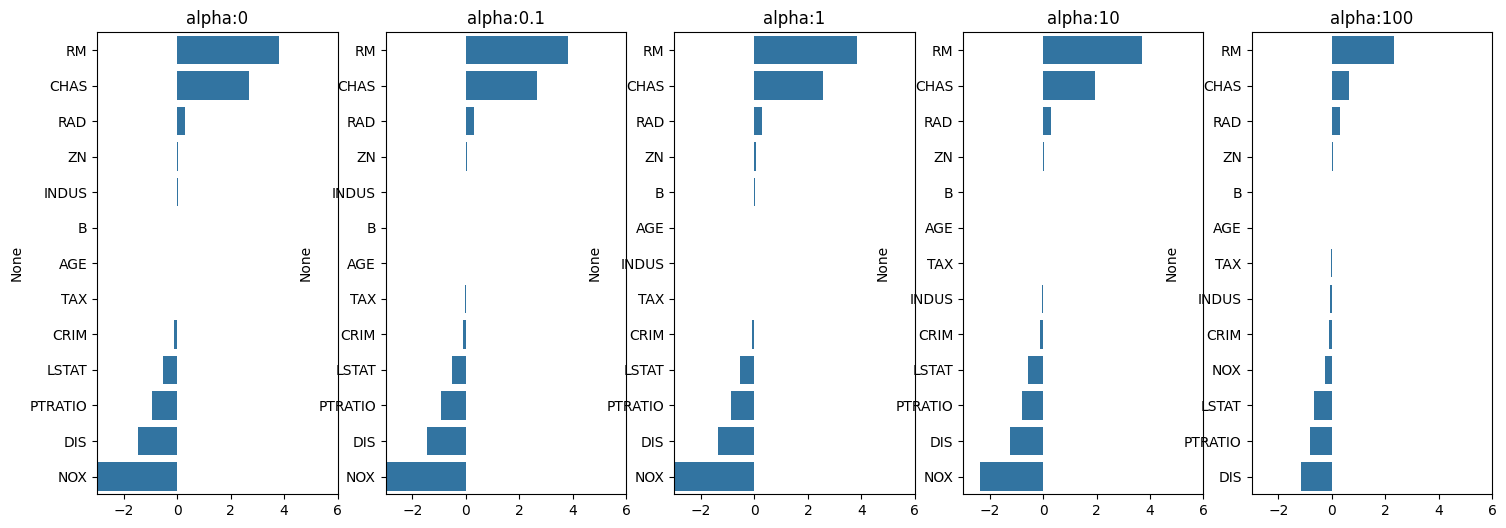

In [ ]:
import matplotlib.pyplot as plt

# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 계속 증가시킬수록 회귀 계수의 값은 지속적으로 작아짐을 알 수 있다. 특히 NOX 피처의 경우 alpha 값을 계속 증가시킴에 따라 회귀계수가 크게 작아지고 있다.

In [ ]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값을 계속 증가시킬수록 회귀 계수의 값은 지속적으로 작아짐을 알 수 있다. 하지만 릿지 회귀의 경우 회귀계수를 0으로 만들지는 않는다.



---



### 라쏘 회귀

- W의 절댓값에 패널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘 회귀이다. 라쏘 회귀 비용함수의 목표는 RSS(W) + alpha*|W| 식을 최소화하는 W를 찾는 것이다.
- L2규제가 회귀 계수의 크기를 감소시키는 데 반해, L1규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거한다.
- 사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현한다. Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당한다.

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data , y_target)
        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
        coeff = pd.Series(data=model.coef_ , index=X_data.columns )
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


alpha가 0.07일 때 5.612로 가장 좋은 평균 RMSE를 보여준다. 앞의 릿지 평균 5.518보다는 약간 떨어지는 수치지만, LinearRegression 평균인 5.829보다는 향상됐다.

In [ ]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있다. 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.



---



### 엘라스틱넷 회귀

- L2규제와 L1규제를 결합한 회귀
- 엘라스틱넷 회귀 비용함수의 목표는 RSS(W) + alpha2*(W^2) + alpha1 * |W| 식을 최소화하는 W를 찾는 것이다.
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우 이들 중에서 중요 피처만을 셀렉하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강한데, 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수도 있다.
- 엘라스틱넷 회귀는 이를 완화하기 위해 L2규제를 라쏘 회귀에 추가한 것이다.
- 단점은 수행시간이 오래 걸린다는 것이다

- 사이킷런은 ElasticNet 클래스를 통해 엘라스틱넷 회귀를 구현한다.
- ElasticNet 클래스의 주요 생성 파라미터는 alpha와 l1_ratio이다.
- 이때 ElasticNet 클래스의 alpha는 Ridge와 Lasso 클래스의 alpha 값과는 다르다. (엘라스틱 규제는 a*L1 + b*L2로 정의될 수 있고, a는 L1규제의 alpha값, b는 L2규제의 alpha값으로, **ElasticNet 클래스의 alpha 값은 a+b이다.**)
- **ElasticNet 클래스의 l1_ratio 파라미터 값은 a / (a+b)**이다. l1_ratio가 0이면 a가 0이므로 L2규제와 동일하고, 1이면 b가 0이므로 L1규제와 동일하다

In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정 (alpha값의 변화만 살피기 위함)
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [ ]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 0.5일 때 RMSE가 5.467로 가장 좋은 예측 성능을 보이고 있다. alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있다.



---



**선형 회귀 모델을 위한 데이터 반환**

- 선형 회귀모델은 일반적으로 피처와 타깃값의 분포가 정규분포 형태를 매우 선호한다. skew된 형태일 경우 예측 성능에 부정적인 영향을 미치므로, **선형회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행**하는 것이 일반적임.
- 이런 데이터 스케일링/정규화작업을 선행한다해서 무조건 예측 성능이 향상되는 것은 아니다. 일반적으로 중요 피처나 타깃값의 분포가 심하게 왜곡됐을 경우 이러한 변환 작업을 수행한다.

- 사이킷런을 이용해 피처 데이터 세트에 적용하는 변환 작업(이미지), 타깃값의 경우는 일반적으로 로그 변환 적용
<img src="https://drive.google.com/uc?export=view&id=15vkBI9LtT0b9nRWEsEBG38_Rge0zkrkr" width="650" height="250">



In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,
                                         include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538 

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴

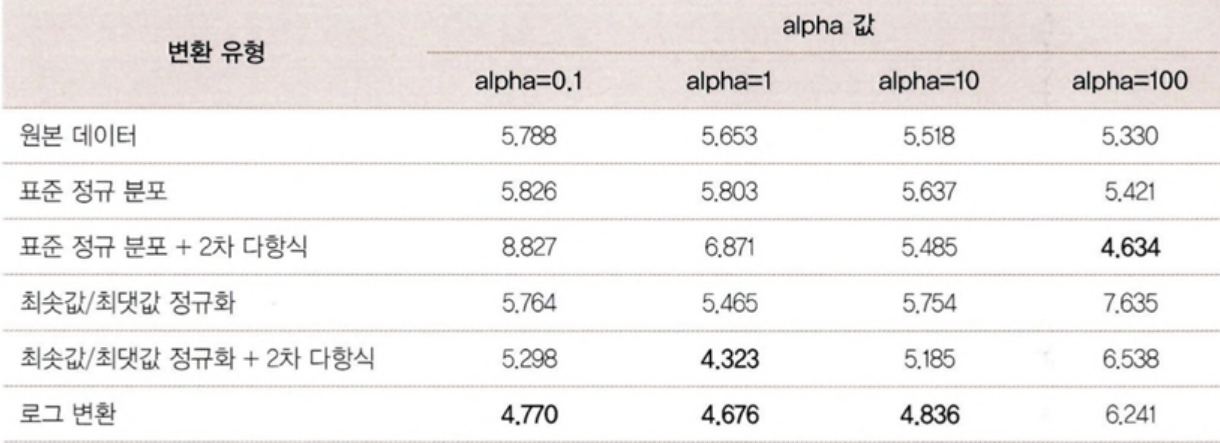


표준 정규 분포와 최솟값/최댓값 정규화로 피처 데이터를 변경해도 성능 상의 개선은 없다. 표준 정규 분포로 일차변환 후 2차 다항식 변환을 했을 때 alpha=100에서 4.634로 성능이 개선됐으며, 최솟값/최댓값 정규화로 일차변환 후 2차 다항식 변환을 했을 때 alpha=1에서 4.323으로 성능이 개선됐다. 다항식변환은 피처개수가 많을 경우 적용하기 힘들며 많은 시간이 소모되어 적용에 한계가 있다. 반면 로그변환을 보면 alpha가 0.1, 1, 10인 경우 모두 좋은 성능 향상이 있음을 알 수 있다.

🥕일반적으로 선형 회귀를 적용하려는 데이터 세트에 데이터값의 분포가 심하게 왜곡되어 있는 경우에 이처럼 로그 변환을 적용하는 것이 좋은 결과를 기대할 수 있다.



---



## 5.7 로지스틱 회귀

- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘이다.
- 로지스틱 회귀가 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid)함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주에 확률에 따라 분류를 결정한다는 것이다.
- 많은 자연,사회 현상에서 특정 변수의 확률값은 선형이 아니라 위의 시그모이드 함수와 같이 S자 커브 형태를 가진다.  

* 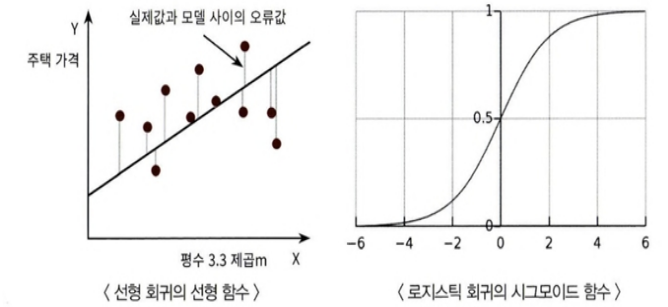
- 지금까지는 연속형 값을 구하는 데 회귀를 사용했지만, 이젠 분류문제에 적용한다.
- 종양의 크기에 따라 악성(1)인지 그렇지 않은지(0)를 회귀를 이용해 1과 0의 값으로 예측하는 것이다.
- [왼쪽 그래프] 종양 크기에 따라 악성이 될 확률이 높다고 한다면 X축을 종양크기, Y축을 악성 종양여부로 표시하고, 이에 회귀를 적용하면 회귀 라인은 0과 1을 제대로 분류하지 못하고 있다. (정확도 낮음)
- [오른쪽 그래프] 하지만 S자 커브 형태의 시그모이드 함수를 이용하면 더 정확하게 0과 1에 대해 분류할 수 있을 것이다.  

사이킷런의 LogisticRegression 클래스를 이용하여 위스콘신 유방암 데이터 세트 기반에서 로지스틱 회귀로 암 여부를 판단해보자

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

선형 회귀 계열의 로지스틱 회귀는 데이터의 정규 분포도에 따라 예측 성능 영향을 받을 수 있으므로 데이터에 먼저 정규분포 형태의 표준 스케일링 적용

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1] # 클래스 1(양성)에 대한 확률

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test , lr_preds_proba)))

accuracy: 0.977
roc_auc: 0.995


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)

    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc: {2:.3f}'.format(
        solver,
        accuracy_score(y_test, lr_preds),
        roc_auc_score(y_test, lr_preds_proba)
    ))

solver:lbfgs, accuracy: 0.977, roc_auc: 0.995
solver:liblinear, accuracy: 0.982, roc_auc: 0.995
solver:newton-cg, accuracy: 0.977, roc_auc: 0.995
solver:sag, accuracy: 0.982, roc_auc: 0.995
solver:saga, accuracy: 0.982, roc_auc: 0.995


In [ ]:
from sklearn.model_selection import GridSearchCV

params={'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


solver와 max_iter외에도 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터로 penalty와 C가 있다. penalty는 규제의 유형을 설정하며 'l2'설정시 L2규제를 'l1'설정시 L1규제를 뜻한다. C는 규제 강도를 조절하는 alpha값의 역수이다. C가 작을수록 규제강도가 크다.



---



## 5.8 회귀트리

- 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다.
* <img src="https://drive.google.com/uc?export=view&id=1NtZkOj44_iHXbdNCYJZY0Z3fQGLdeYYp" width="500" height="210">
- 단 하나의 피처 데이터세트만 있다고 가정하면, X값의 균일도를 반영한 지니 계수에 따라 다음 그림의 왼쪽과 같이 분할할 수 있다.

- 결정트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 4장 분류에서 소개한 모든 트리 기반 알고리즘은 분류 뿐 아니라 회귀도 가능하다.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<Axes: xlabel='None', ylabel='None'>

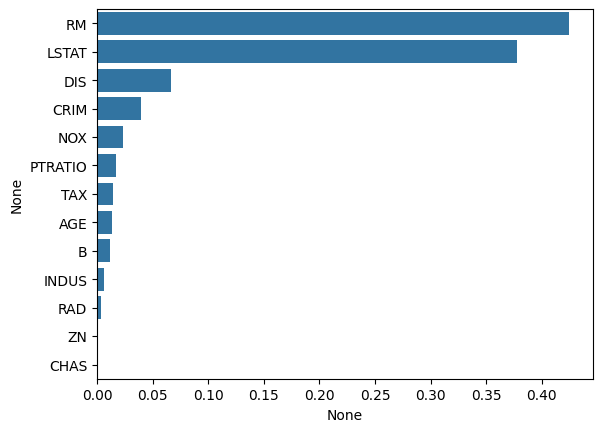

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(100, 2)


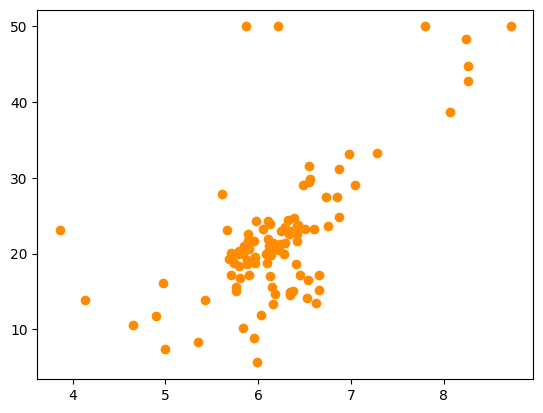

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

보스턴 데이터 세트의 개수를 100개만 샘플링하고 RM과 PRICE칼럼만 추출한다. 이는 2차원 평면상에서 X축에 독립변수인 RM, Y축에 종속변수인 PRICE만을 가지고 좀 더 직관적으로 예측값을 시각화하기 위한 것

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

보스턴 데이터 세트에 대해 LinearRegression과 DecisionTreeRegressor를 max_depth를 각각 2,7로 해서 학습했다. 이렇게 학습된 Regressor에 RM값을 4.5~8.5까지의 100개의 테스트 데이터 세트로 제공했을 때 예측값을 구했다

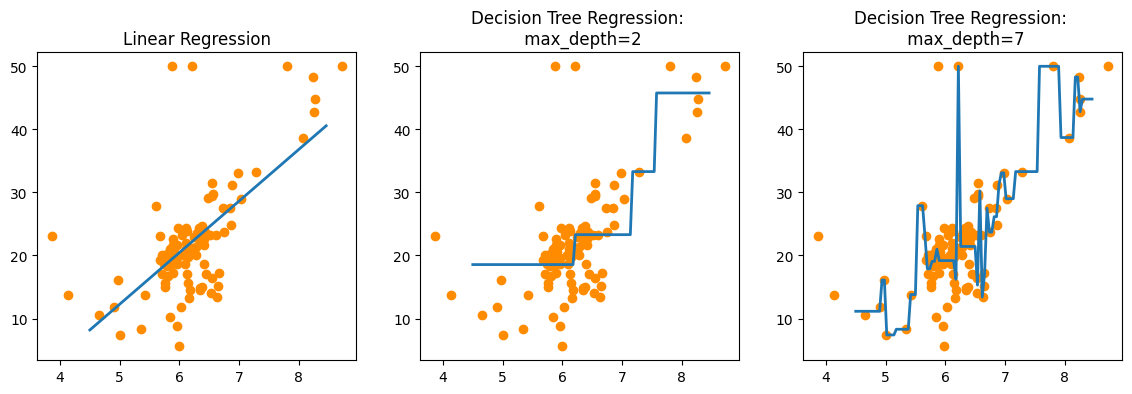

In [ ]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

선형 회귀는 직선으로 예측 회귀선을 표현하는 데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만든다. DecisionTreeRegressor의 max_depth=7인 경우 학습 데이터 세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음을 알 수 있다.